In [54]:
from IPython.display import HTML

HTML(
'''
<script>
    code_show=false; 
    function code_toggle() {
         if (!code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
        } 
        $(document).ready(code_toggle);
</script>

<form action="javascript:code_toggle()">
    <input type="submit" value="Show code">
</form>
'''
)

<a id='index'></a>
# ARIMA and Seasonal ARIMA

* [Time Series Data Visualisation](#visualisation)
* [Making Series Stationary](#stationary)
* [Autocorrelation and Partial Autocorrelation Plots](#autocorrelation)
* [ARIMA Model](#arima)
* [Predictions](#predictions)

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
plt.rcParams['font.size'] = 20

<a id='visualisation'></a>
## Time Series Visualisation

[back to index](#index)

In [7]:
data = pd.read_csv('monthly-milk-production-pounds-p.csv')
data.columns = ['Month', 'Milk in Pounds per Cow']
data.drop(168, axis=0, inplace=True)
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


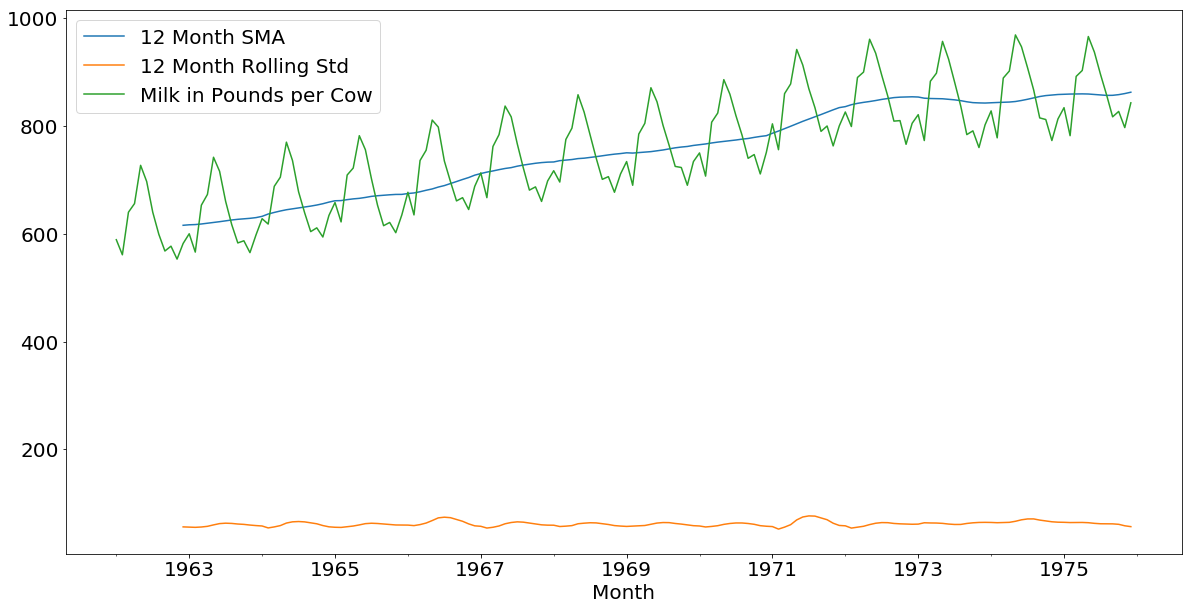

In [13]:
series = data['Milk in Pounds per Cow']

series.rolling(12).mean().plot(
    figsize=(20, 10),
    label='12 Month SMA'
)

series.rolling(12).std().plot(
    label='12 Month Rolling Std'
)
series.plot()

plt.legend();

### Decomposition

In [15]:
decomposed = seasonal_decompose(series)

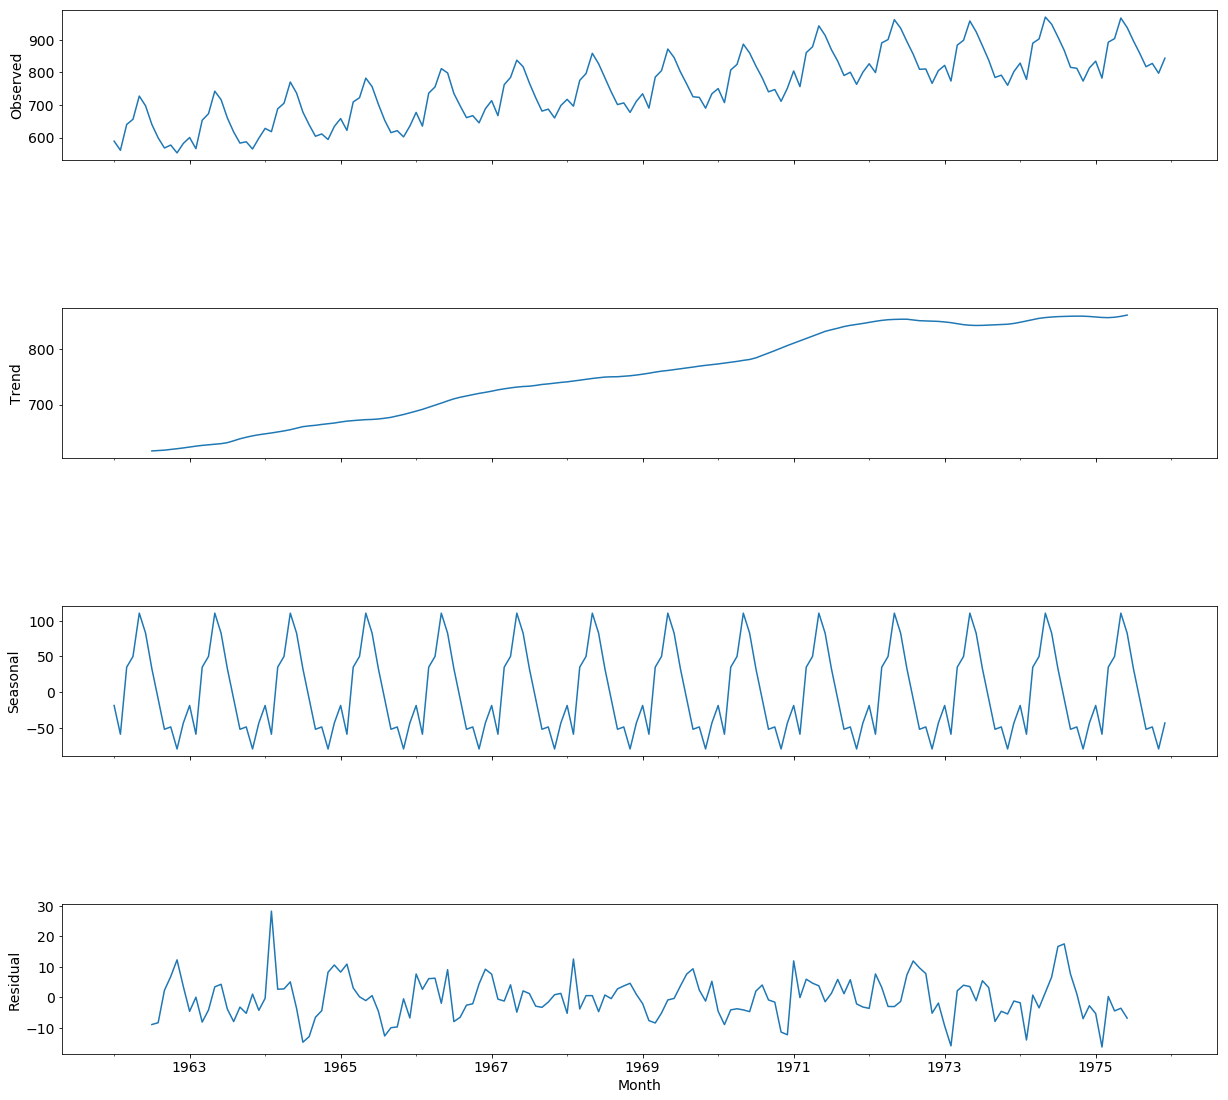

In [28]:
plt.rcParams['font.size'] = 14
fig = decomposed.plot()
fig.set_size_inches(20, 20)

<a id='stationary'></a>
## Making Series Stationary

[back to index](#index)

In [39]:
def is_stationary(series, alpha=0.05):
    result = adfuller(series)
    print("Augmented Dicky-Fuller Test @ alpha = %.3f:\nSeries is stationary: %s (p-val = %.3f)" % 
          (alpha, result[1] <= alpha, result[1]))

In [40]:
is_stationary(series)

Augmented Dicky-Fuller Test @ alpha = 0.050:
Series is stationary: False (p-val = 0.627)


### First Difference

Augmented Dicky-Fuller Test @ alpha = 0.050:
Series is stationary: True (p-val = 0.030)


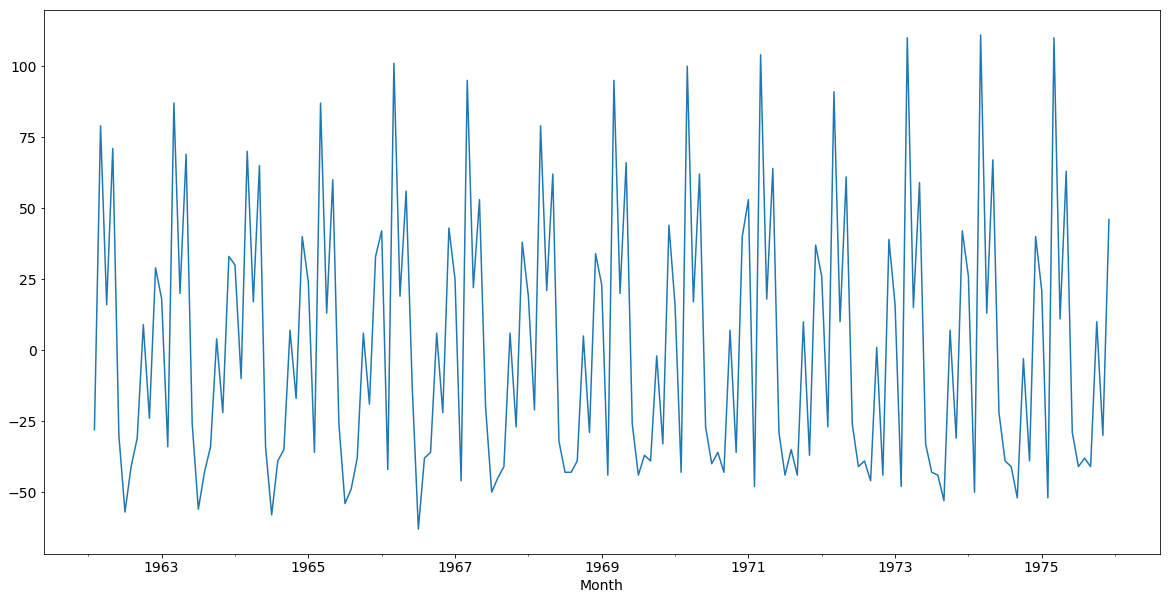

In [45]:
first_difference = series - series.shift(1)
first_difference.plot(
    figsize=(20, 10)
)
is_stationary(first_difference.dropna())

### Second Difference

Augmented Dicky-Fuller Test @ alpha = 0.050:
Series is stationary: True (p-val = 0.000)


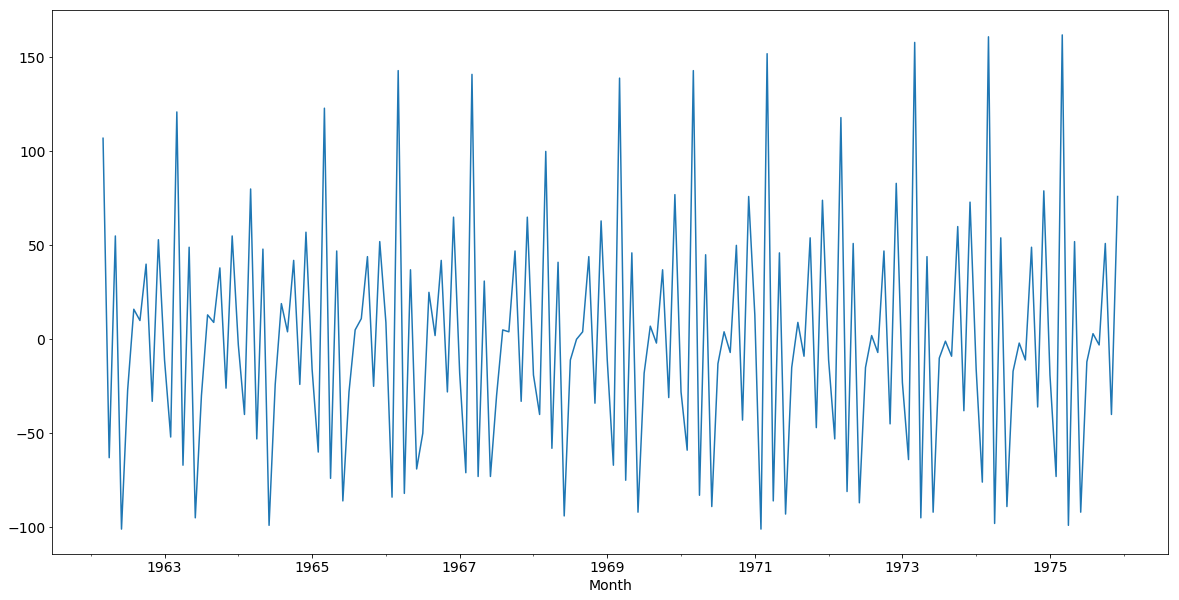

In [44]:
second_difference = first_difference - first_difference.shift(1)
second_difference.plot(
    figsize=(20, 10)
)
is_stationary(second_difference.dropna())

### Seasonal Difference

In [46]:
seasonal_difference = series - series.shift(12) # shift by the entire season

Augmented Dicky-Fuller Test @ alpha = 0.050:
Series is stationary: False (p-val = 0.161)


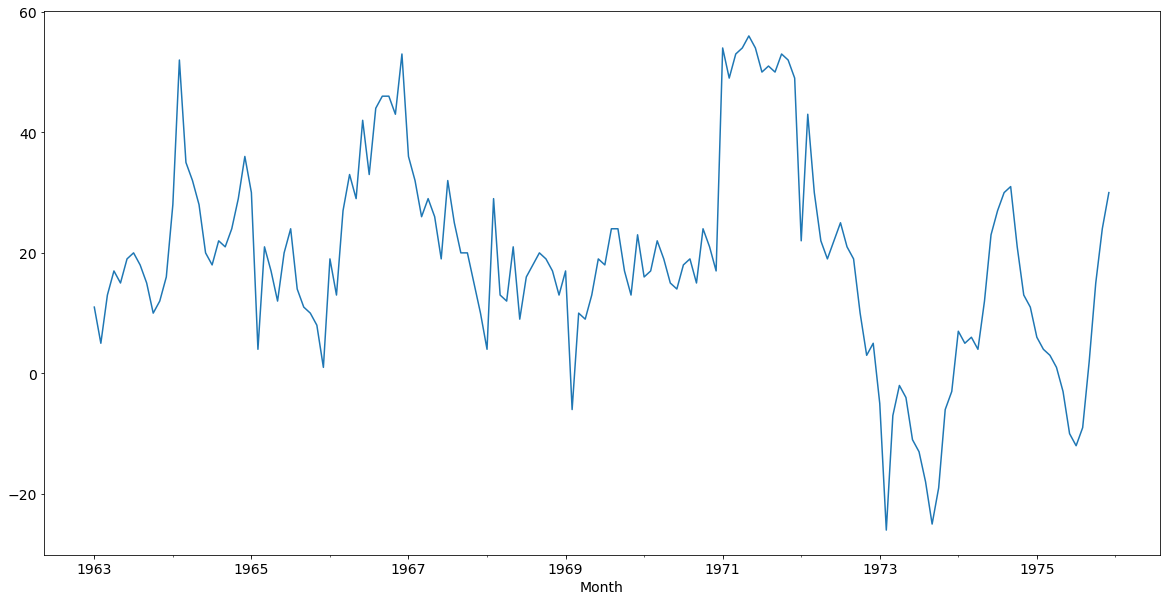

In [47]:
seasonal_difference.plot(
    figsize=(20, 10)
)
is_stationary(seasonal_difference.dropna())

### Seasonal First Difference

Augmented Dicky-Fuller Test @ alpha = 0.050:
Series is stationary: True (p-val = 0.000)


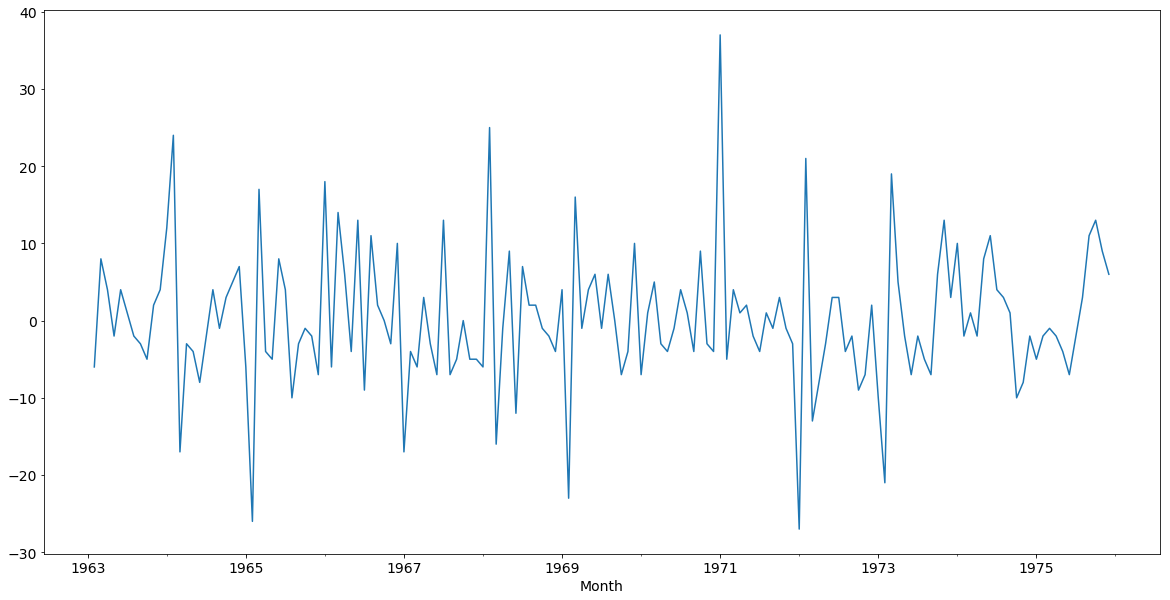

In [48]:
seasonal_first_difference = first_difference - first_difference.shift(12)
seasonal_first_difference.plot(
    figsize=(20, 10)
)
is_stationary(seasonal_first_difference.dropna())

<a id='autocorrelation'></a>
## Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x and this defines the plot.

There is a lot of great information for identifying and interpreting ACF and PACF [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag
<br>
<br>
* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

### Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

### $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

See this [link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) for full details on this.

[back to index](#index)

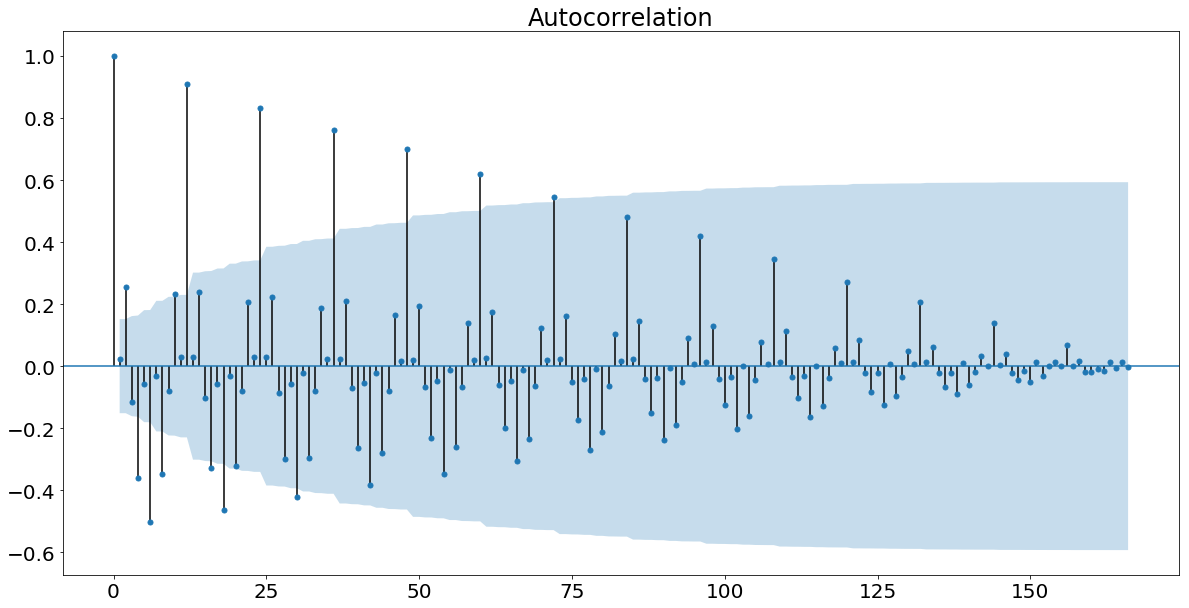

In [51]:
plt.rcParams['font.size'] = 20
fig = plot_acf(first_difference.dropna())
fig.set_size_inches(20, 10)

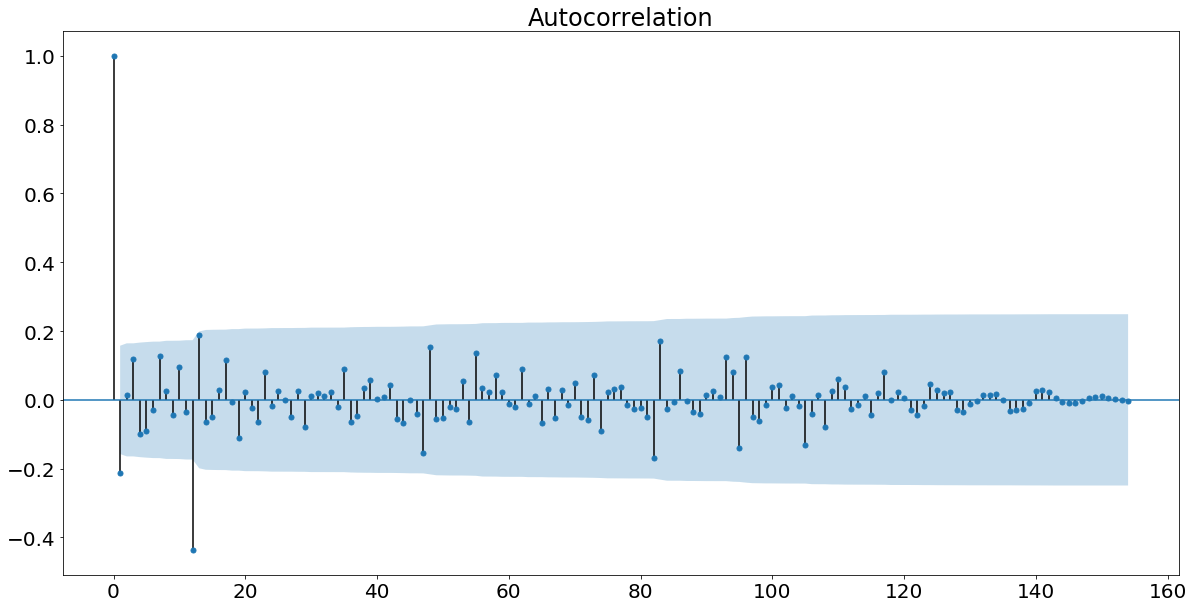

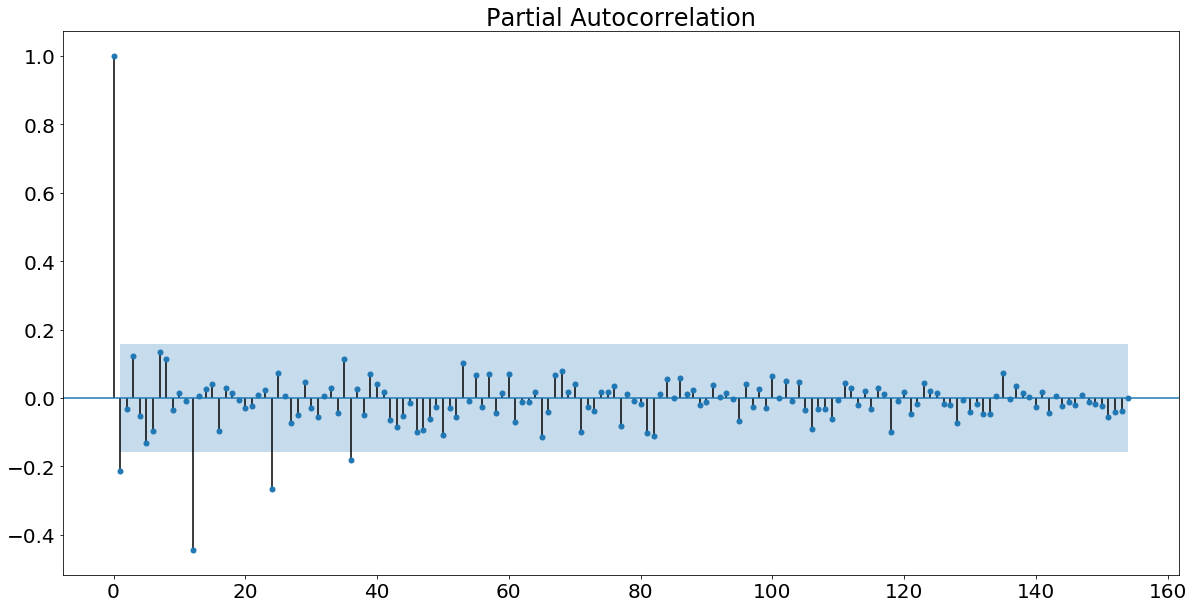

In [57]:
fig = plot_acf(seasonal_first_difference.dropna())
fig.set_size_inches(20, 10)

fig = plot_pacf(seasonal_first_difference.dropna())
fig.set_size_inches(20, 10)

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

<a id='arima'></a>
## ARIMA Model

### Seasonal ARIMA

[back to index](#index)

In [61]:
help(sm.tsa.statespace.SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters. `d` must be an integer
 |      indicating the integration order of the process, while
 |      `p` and `q` may either be an integers indicating the AR and MA
 |      orders (so that all lags up to those orders are included) or else
 |      iterables giving specific AR and / or MA lags to include. Default is
 |      an AR(1) model: (1,0,0).
 |  seasonal_order : iterable, optional
 |      The (P,D,Q,s) order of the 

In [58]:
# Seasonal ARIMA
model = sm.tsa.statespace.SARIMAX(
    series,
    order=(0, 1, 0),
    seasonal_order=(1, 1, 1, 12)
)

results = model.fit()

In [60]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Sat, 13 Jan 2018   AIC                           1074.131
Time:                                    14:52:22   BIC                           1083.503
Sample:                                01-01-1962   HQIC                          1077.934
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.761      0.000      -0.785      -0.387
sigma2        55.5118      5.356     10.365      0.000      45.015      66.009
===================================================================================
Ljung-Box (Q):                       33.48   Jarque-Bera (JB):                32.04
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.77
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

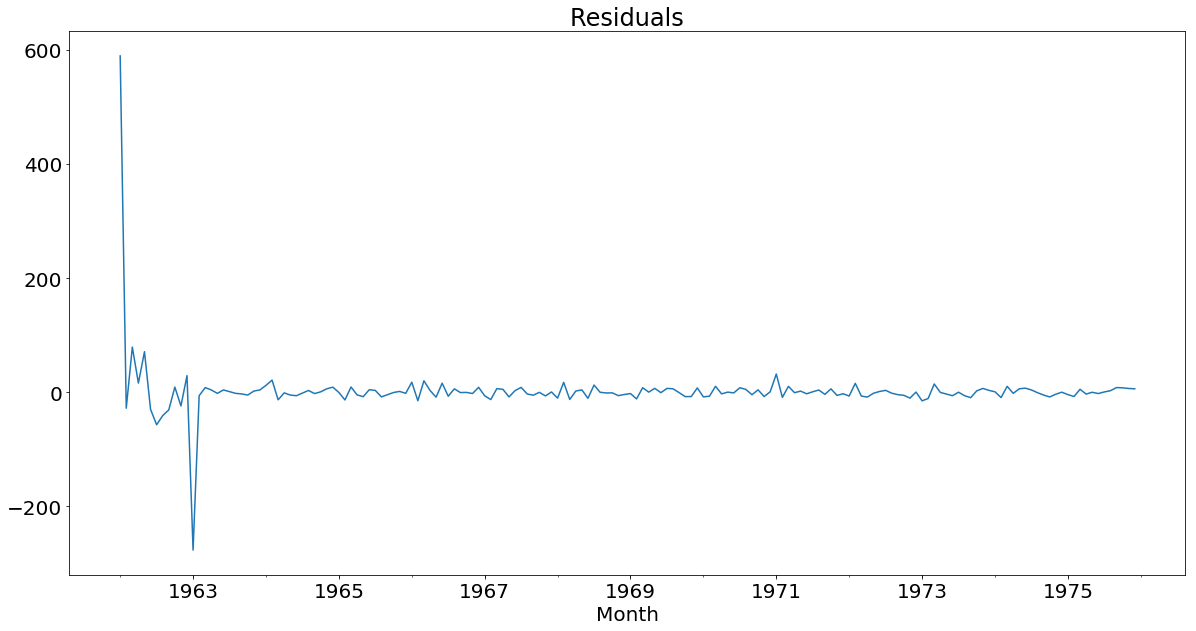

In [70]:
results.resid.plot(
    figsize=(20, 10),
    title='Residuals'
);

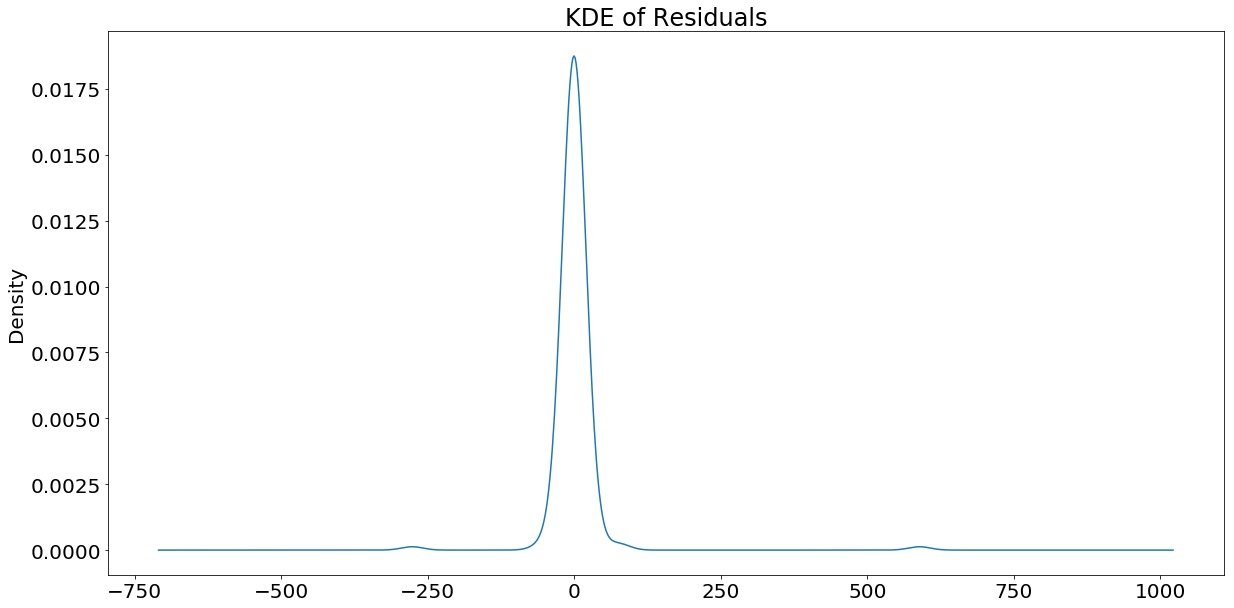

In [72]:
results.resid.plot(
    kind='kde',
    figsize=(20, 10),
    title='KDE of Residuals'
);

<a id='predictions'></a>
## Predictions

### Training 

[back to index](#index)

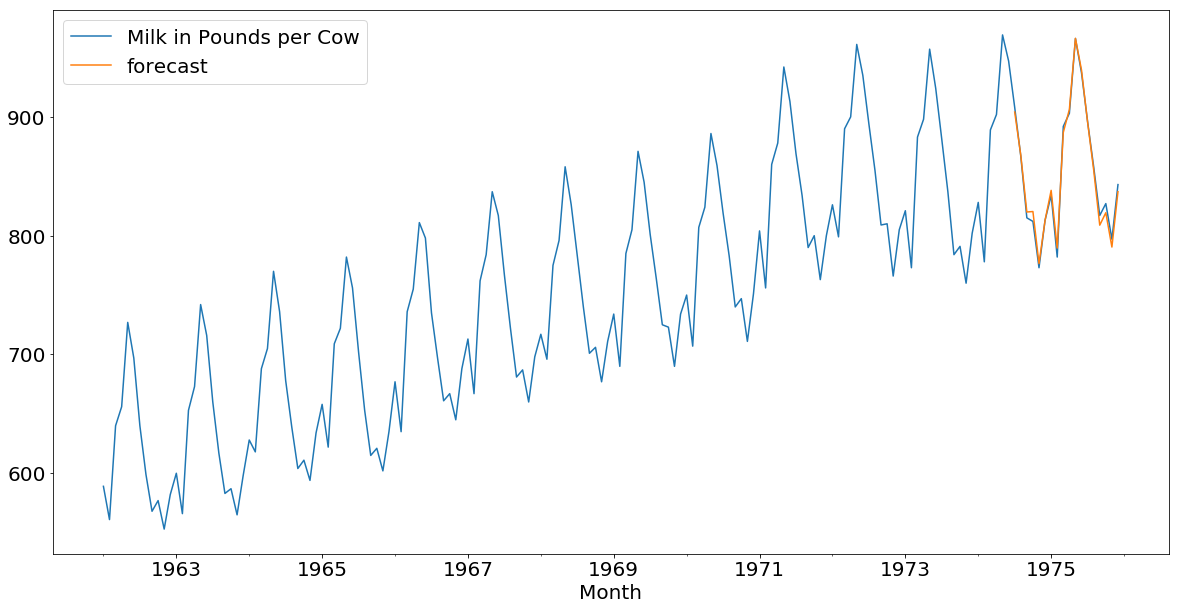

In [75]:
data['forecast'] = results.predict(start=150, end=168)
data[[
    'Milk in Pounds per Cow',
    'forecast'
]].plot(
    figsize=(20, 10)
);

### Future Forecast

Add 24 months for future predictions.

In [76]:
from pandas.tseries.offsets import DateOffset # for adding more periods

In [77]:
future_dates = [
    data.index[-1] + DateOffset(months=x) for x in range(1, 24)
]

In [79]:
future_data = pd.DataFrame(
    index=future_dates,
    columns=data.columns
)

future_data = pd.concat([data, future_data])

In [80]:
future_data['forecast'] = results.predict(start=168, end=192)

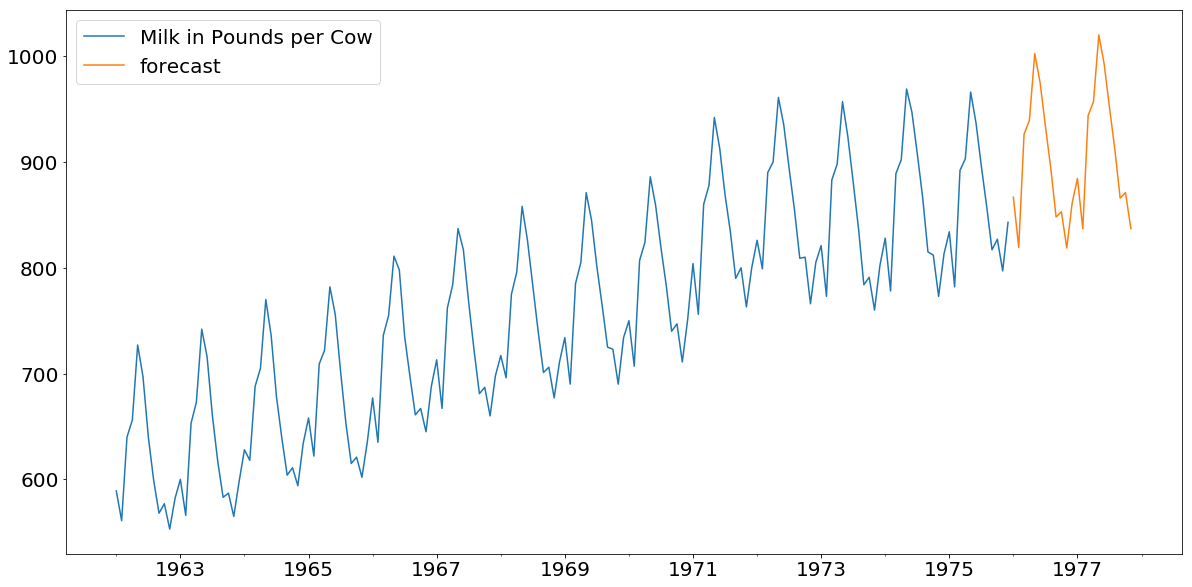

In [82]:
future_data[[
    'Milk in Pounds per Cow',
    'forecast'
]].plot(figsize=(20, 10));